# Benchmarking Julia Code

This notebook is largely inspired by [this excellent blog post](https://opensourc.es/blog/matrix-multiplication-performance/) and illustrates how to benchmark Julia code, as well as a few useful tricks for optimizing it. You'll need a couple of packages to get it running on your machine. Simply run the next cell to install them.

**NOTE:** Installing packages can take a couple of minutes

In [1]:
using Pkg
Pkg.add("BenchmarkTools")
Pkg.add("StatsPlots")
Pkg.add("LoopVectorization")

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


Precompiling 

project...


  ? AbbreviatedStackTraces

  ✓ ArrayInterface → ArrayInterfaceBlockBandedMatricesExt


  1 dependency successfully precompiled in 4 seconds. 767 already precompiled.
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version
  1 dependency failed but may be precompilable after restarting julia
   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


Precompiling 

project...


  ? AbbreviatedStackTraces

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


Precompiling 

project...


  ? AbbreviatedStackTraces

In this notebook, we'll examine the performance of the humble matrix multiplication. We'll start with a naive implementation, and gradually optimize it.

In [1]:
# This function performs the update C = C + A*B without allocating memory
function simple_mul!(C,A,B)
    m,n = size(C)
    l = size(A,2)
    for i in 1:m, j in 1:n, k in 1:l
        C[i,j] += A[i,k]*B[k,j]
    end
end

simple_mul! (generic function with 1 method)

In [2]:
n = 256
A = rand(n,n);
B = rand(n,n);
C = rand(n,n);

The Julia standard provides a macro called `@time` to evaluate the running time of an expression (e.g. a function call)

In [3]:
@time simple_mul!(C,A,B)

  0.064231 seconds (11.26 k allocations: 785.501 KiB, 52.14% compilation time)


Note that the above mentions allocations and time spent for compiling the function, so it is not representative of the real performance. If we run the macro again, we see that it takes about 20 ms to compute the product of two 256 times 256 matrices.

In [4]:
@time simple_mul!(C,A,B)

  0.032840 seconds


Using `@time` is fine to get a quick idea of performance, but it only measures the time for one function call. For proper benchmarking, we'll need to bust out the power tools.

Luckily for us, the `BenchmarkTools` package provides just that. It exports several macros, including `@btime` and `@benchmark` which run the expression multiple times to get a better estimate of its performance.

In [5]:
using BenchmarkTools

In [6]:
b_simple = @benchmark simple_mul!(C,A,B)

BenchmarkTools.Trial: 130 samples with 1 evaluation.
 Range (min … max):  33.345 ms … 53.205 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     37.748 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   38.587 ms ±  3.355 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

           ▃█ ▆     ▁                                          
  ▃▃▃▁▄▆▆▇███▃██▄██▇█▇▄▇▇▆█▃▄▄▃▃▆▃▁▃▄▇▁▃▁▄▃▃▁▃▃▁▃▁▁▁▃▁▁▃▁▁▁▁▃ ▃
  33.3 ms         Histogram: frequency by time        49.3 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

Looking at the results above, it seems we're a bit under 20 ms for our simple matmul. Let's compare it with the equivalent from the standard library.

In [7]:
using LinearAlgebra
b_mul = @benchmark mul!(C,A,B)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  239.570 μs …  12.085 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     438.395 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   460.838 μs ± 259.050 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▅▄▃▃▃▂▁▁▁  ▆█▅▄▃▂▂▂▁▁▁▁▁ ▁▁                                   ▁
  ██████████▇███████████████████▇▇▇▇▆▆▅▇▆▆▇▅▆▅▅▅▆▆▅▅▄▅▅▅▅▅▄▅▃▅▄ █
  240 μs        Histogram: log(frequency) by time       1.23 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

That's quite the difference, as the standard library is about 20 times faster.

There are a couple of simple things we can do to improve on our implementation. First, we can change the order of the loops. Julia stores its arrays in Column Major Order, so we'll get better performance if we access the array elements column by column.

In [8]:
function better_mul!(C,A,B)
    m,n = size(C)
    l = size(A,2)
    for j in 1:n, k in 1:l, i in 1:m
        C[i,j] += A[i,k]*B[k,j]
    end
end

better_mul! (generic function with 1 method)

In [9]:
b_better = @benchmark better_mul!(C,A,B)

BenchmarkTools.Trial: 320 samples with 1 evaluation.
 Range (min … max):  13.139 ms … 25.971 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     15.070 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   15.614 ms ±  1.891 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

       ▅██▃▇▅  ▁ ▂ ▂                                           
  ▃▃▅▅▆███████▆█▇█▇███▇▄▇▇▇▄▃█▃▃▃▄▃▅▃▃▃▃▃▄▄▃▃▃▄▃▁▃▃▁▃▃▃▁▃▃▃▃▃ ▄
  13.1 ms         Histogram: frequency by time        21.2 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

That shaved a bit of performance, but still far from `mul!`. 

The reason reordering the loops improved performance is that modern computer memory is optimized for accessing contiguous areas of memory, so when traversing a Julia matrix by row instead of by column, we are getting what is called "cache misses" where we are jumping between areas of memory that are far apart.

Another simple trick we can use is turning off bounds checking. When accessing a Julia array, the Julia runtime checks that the index we're trying to access is valid (i.e. within the bounds of the array).

If we already know that the index is valid, we can use the macro `@inbounds` to tell the Julia runtime to skip checking it.

In [10]:
function inbounds_mul!(C,A,B)
    m,n = size(C)
    l = size(A,2)
    for j in 1:n, k in 1:l, i in 1:m
        @inbounds C[i,j] += A[i,k]*B[k,j]
    end
end

inbounds_mul! (generic function with 1 method)

In [11]:
b_inbounds = @benchmark inbounds_mul!(C,A,B)

BenchmarkTools.Trial: 1482 samples with 1 evaluation.
 Range (min … max):  2.573 ms …   9.661 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.046 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.338 ms ± 906.292 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ██▃▂▁                                                        
  ████████▆▆▆▆▅▅▆▄▄▃▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  2.57 ms         Histogram: frequency by time        6.89 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

As we can see, just adding a single macro call improved performance by 10. Not bad! But we can still do better.

The next thing to try is using the basic multithreading support from the standard library.

In [13]:
Threads.nthreads()

1

Unfortunately, I can't get Jupyter notebooks to use multiple threads, so we'll have to do that part in the REPL. Just copy the next two cells in a Julia REPL (You'll have to open a REPL with `julia --threads=4` to start julia with multiple threads available).

In [14]:
function threaded_mul!(C,A,B)
    m,n = size(C)
    l = size(A,2)
    Threads.@threads for j in 1:n # NB. We can only apply this to the outer loop
        for k in 1:l, i in 1:m
          @inbounds C[i,j] += A[i,k]*B[k,j]
        end
    end
end

threaded_mul! (generic function with 1 method)

In [15]:
n = 256; A = rand(n,n); B = rand(n,n); C = rand(n,n)
using BenchmarkTools
b_threaded = @benchmark threaded_mul!(C,A,B)

BenchmarkTools.Trial: 2498 samples with 1 evaluation.
 Range (min … max):  1.744 ms …   3.603 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.950 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.996 ms ± 190.017 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

       ▃▆█▅▅▄▃▁▂▃▂                                             
  ▃▅▅▇██████████████▆█▆▆▆▄▅▅▅▄▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▁▂ ▄
  1.74 ms         Histogram: frequency by time        2.74 ms <

 Memory estimate: 688 bytes, allocs estimate: 7.

In the above, we get no speedup because this Jupyter Notebook only gets a single thread. When I run it in the REPL with 4 threads, I'm getting a median of 612 µs (slightly faster than `mul!`), but this does incur costs as we need to allocate memory for the `@threads` macro.

To finish this notebook, we'll use the `LoopVectorization` package, which export a magic macro called `@turbo` which performs a bunch of optimization on a loop, including using SIMD instructions when it can.

In [12]:
using LoopVectorization

In [13]:
function turbo_mul!(C,A,B)
    m,n = size(C)
    l = size(A,2)
    @turbo for j in 1:n # NB. We can only apply this to the outer loop
        for k in 1:l, i in 1:m
            @inbounds C[i,j] += A[i,k]*B[k,j]
        end
    end
end

turbo_mul! (generic function with 1 method)

In [14]:
b_turbo = @benchmark turbo_mul!(C,A,B)

BenchmarkTools.Trial: 5876 samples with 1 evaluation.
 Range (min … max):  666.708 μs …   3.790 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     772.412 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   841.586 μs ± 212.185 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ██▆                                                         
  ▁▂▃████▆▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  667 μs           Histogram: frequency by time         1.76 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

And *voila*! We actually managed to be a little faster than `mul!` in this case.
All it took was a single macro call.

(NB. Keep in mind we're only looking at matrices of size 256, and our implementations don't check all the things they should to be correct).

Let's wrap up by comparing all our results on a plot. Aside from printing a pretty histogram, `@benchmark` actually returns the data from all its samples in an object, so we can access them.

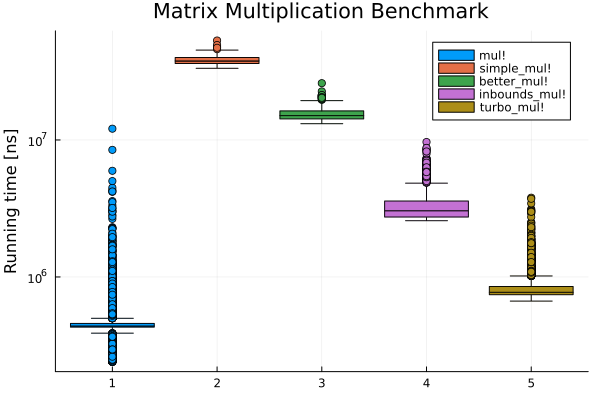

In [15]:
using StatsPlots

boxplot(b_mul.times, label="mul!",
    yscale = :log10,
    ylabel = "Running time [ns]",
    title = "Matrix Multiplication Benchmark"
)
boxplot!(b_simple.times, label="simple_mul!")
boxplot!(b_better.times, label="better_mul!")
boxplot!(b_inbounds.times, label="inbounds_mul!")
#boxplot!(b_threaded.times, label="threaded_mul!")
boxplot!(b_turbo.times, label="turbo_mul!")


In [19]:
savefig("matmul-benchmark.png")

"/home/csimal/Documents/Talks/Julia-CISM/matmul-benchmark.png"